In [ ]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import solveh_banded  
from scipy.signal import savgol_filter
from scipy.optimize import nnls

In [ ]:

class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        """
        Whittaker Smoother.
        Input:
            signal: Array-like, the input signal to be smoothed.
            smoothness_param: Float, parameter controlling the smoothness.
            deriv_order: Integer, the order of the derivative used in smoothing.
        """
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Create upper triangular banded matrix for smoothing operation.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i, ds in enumerate(diag_sums):
            upper_bands[i, -i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands


    def smooth(self, w):
        """
        Perform the smoothing operation.
        Input:
            w: Array-like, weights for the smoothing process.
        Output:
            Array-like, smoothed signal.
        """
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        try:
            smoothed_signal = solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)
        except np.linalg.LinAlgError:
            print("Error numérico en solveh_banded, se asignará una línea base con NaN.")
            smoothed_signal = np.full_like(self.y, np.nan)  # Devolver NaN si ocurre un error
        return np.nan_to_num(smoothed_signal, nan=0.0, posinf=0.0, neginf=0.0)  # Reemplazar NaN e Inf por 0


def als_baseline(intensities, asymmetry_param=0.001, smoothness_param=5e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False, threshold_min_value=1e-6):
    """
    Asymmetric least squares baseline correction with threshold handling.
    Input:
        intensities: Array-like, original intensities of the signal.
        asymmetry_param: Float, parameter controlling asymmetry.
        smoothness_param: Float, parameter controlling smoothness.
        max_iters: Integer, maximum number of iterations.
        conv_thresh: Float, convergence threshold.
        verbose: Boolean, flag for verbose output.
        threshold_min_value: Float, minimum value below which data will be set to zero.
    Output:
        Array-like, baseline of the signal.
    """
    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param  # Rename for concision.
    w = np.ones(intensities.shape[0])  # Initialize weights.
    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p*mask + (1-p)*(~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i+1, conv)
        if conv < conv_thresh:
            break
        w = new_w
    #else:
        #print('ALS did not converge in %d iterations' % max_iters)

    # Check for very small values and set them to zero
    z[np.abs(z) < threshold_min_value] = 0

    if np.isnan(z).any() or np.isinf(z).any():
        print("Se encontraron valores NaN o Inf en la línea base ajustada.")
        z = np.nan_to_num(z, nan=0.0, posinf=0.0, neginf=0.0)  # Reemplazar NaN e Inf por 0
    return z


def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, baseline for each spectrum.
    """
    bl = df.copy()
    for i in range(len(df)):
        baseline = als_baseline(df.iloc[i, :].values)
        bl.iloc[i, :] = baseline
    return bl


def filtrar_por_comparacion_picos(df, columna_ref=800, columna_objetivo=920, factor=0.3):
    """
    Filtra un DataFrame basado en la comparación de intensidades entre dos columnas especificadas.

    Args:
        df (pd.DataFrame): DataFrame que contiene las columnas de intensidades de espectros.
        columna_ref (int): Columna de referencia para la comparación de intensidad.
        columna_objetivo (int): Columna objetivo que se compara con la referencia.
        factor (float): Factor que se suma a la columna de referencia para definir el umbral.

    Returns:
        pd.DataFrame: DataFrame filtrado donde las intensidades de la columna objetivo son menores o iguales a la suma de la columna de referencia y el factor.
    """
    if columna_ref in df.columns and columna_objetivo in df.columns:
        filtro = df[columna_objetivo] <= (df[columna_ref] + factor)
        df_filtrado = df[filtro].copy()  # Devolver una copia del DataFrame filtrado
    else:
        print(f"Las columnas {columna_ref} cm-1 o {columna_objetivo} cm-1 no se encontraron en el DataFrame.")
        df_filtrado = df.copy()  # Devolver una copia del DataFrame original en caso de que las columnas no existan
    return df_filtrado


def valida(head, centro):
    N = len(head)  # Number of elements in 'head'
    validas = []  # List to store the indices of valid values
    extremoIzqda = centro - 15  # Lower limit of the range
    extremoDcha = centro + 15  # Upper limit of the range
    for i in range(N):
        valor = float(head[i])  # Convert the current value to float
        if extremoIzqda < valor < extremoDcha:  # Check if the value is within the range
            validas.append(i)  # If within range, add the index to the list of valid indices
    return validas  # Return the list of valid indices


def SNR(df, n):
    """
    Calcula la relación señal-ruido (SNR) y filtra espectros con SNR mayor a un umbral dado.

    Args:
        df (pd.DataFrame): DataFrame con los datos espectrales.
        n (int): Umbral para filtrar basado en la SNR.
        imprimir (bool): Indica si imprimir el espectro promedio y la desviación estándar.

    Returns:
        tuple:
            - Series con el SNR calculado para cada espectro.
            - DataFrame con los espectros filtrados que tienen SNR mayor que el umbral.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("El argumento 'df' no es un DataFrame")
    
    # Definir columnas categóricas que se podrían eliminar
    categorical_columns = ["name", "t_exp", "date"]
    
    # Eliminar columnas categóricas si existen en el DataFrame
    columns_to_remove = [col for col in categorical_columns if col in df.columns]
    df_spectra = df.drop(columns=columns_to_remove, errors='ignore')

    # Separar columnas categóricas si existían
    df_labels = df[columns_to_remove] if columns_to_remove else None

    head_ruido = valida(df_spectra.columns, 800)
    head_signal = valida(df_spectra.columns, 1000)

    if not head_ruido or not head_signal:
        raise ValueError("No se encontraron valores válidos para ruido o señal en los datos")

    ruido = df_spectra.iloc[:, head_ruido]  # Obtener datos de ruido
    signal = df_spectra.iloc[:, head_signal]  # Obtener datos de señal
    maximo = signal.max(axis=1)  # Calcular el valor máximo de la señal por fila
    std_ruido = ruido.std(axis=1)  # Calcular la desviación estándar del ruido por fila
    relacion = maximo / std_ruido  # Calcular la relación señal-ruido (SNR)

    grupo15 = relacion[relacion > n]  # Filtrar relaciones mayores que el umbral

    grupo15_index = grupo15.index.tolist()
    filtered_index = [idx for idx in grupo15_index if idx in df_spectra.index]

    # Si no se encuentran índices filtrados, devolver un DataFrame vacío
    if not filtered_index:
        return relacion, pd.DataFrame()

    snr = df_spectra.loc[filtered_index, :]

    # Si había columnas categóricas en el DataFrame original, concatenarlas
    if df_labels is not None:
        snr = pd.concat([snr, df_labels.loc[snr.index]], axis=1)


    return relacion, snr  # Retornar el SNR calculado y el DataFrame filtrado



def preprocess_data(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        Tuple of DataFrames: (preprocessed spectral data, baseline data).
    """
    # Apply Savitzky-Golay filter for smoothing.
    X_smooth = savgol_filter(X_filtered, 21, 2)
    X_smooth = pd.DataFrame(X_smooth, columns=X_filtered.columns)

    # Baseline correction.
    bl = find_baseline(X_smooth)
    X_corrected = X_smooth - bl  # Corrected data in original scale

    # Normalize each corrected spectrum.
    X_norm_list = []
    for _, row in X_corrected.iterrows():
        total = np.sum(row)
        if total != 0:
            X_norm_list.append(pd.DataFrame([row / total * 2000]))
        else:
            X_norm_list.append(pd.DataFrame([row]))
    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Standardize data.
    scaler = StandardScaler()
    z_numpy = X_norm.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)

    return X_norm_stdz, bl  # Return both the preprocessed data and the baseline




def standarization(df):
    """
    Preprocessing of spectral data.
    Input:
        baselines: DataFrame, raw spectral data.
    Output:
        DataFrame: Preprocessed spectral data with categorical data concatenated.
    """
    # Separar las columnas categóricasç
    coordinates = df[['X', 'Y']]
    categorical_data = df[['name', 'date', 't_exp', 'medium', 'especie']]
    df = df.drop(columns=['X', 'Y','name', 'date', 't_exp', 'medium', 'especie'])

    # Normalize each corrected spectrum
    X_norm_list = []
    for _, row in df.iterrows():
        total = np.sum(row)
        if total != 0:
            X_norm_list.append(pd.DataFrame([row / total * 2000]))
        else:
            X_norm_list.append(pd.DataFrame([row]))
    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Standardize data
    scaler = StandardScaler()
    z_numpy = X_norm.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=df.columns)

    # Concatenar las columnas categóricas de vuelta al DataFrame preprocesado
    X_norm_stdz = pd.concat([coordinates, X_norm_stdz, categorical_data.reset_index(drop=True)], axis=1)

    return X_norm_stdz



# Función para corregir las entradas del año '23' por '24'
def correct_year(date):
    date_str = str(date)
    if date_str.endswith('23'):
        return date_str[:-2] + '24'
    return date_str

# Función para convertir la columna 'date' en un formato interpretable
def convert_date_format(date):
    if len(str(date)) == 5:
        date_str = '0' + str(date)  # Añadir 0 si tiene 5 dígitos
    else:
        date_str = str(date)
    
    day = int(date_str[:2])
    month = int(date_str[2:4])
    year = int(date_str[4:])
    
    return pd.Timestamp(year=2000 + year, month=month, day=day)



def procesarRaman_carpeta(ruta):
    """
    Procesa los datos de espectros Raman desde una carpeta, considerando solo los espectros que saturan
    por encima de 65000 de intensidad alrededor de 3000 cm⁻¹. Calcula la línea base después de aplicar
    todos los filtros de eliminación de filas, y realiza la interpolación sin recortar las columnas.

    Args:
        ruta (str): La ruta a la carpeta que contiene los archivos de datos de espectros Raman.

    Returns:
        list: Una lista de tuplas que contienen los datos procesados para cada archivo. Cada tupla contiene:
            - El nombre del archivo
            - Las coordenadas
            - Los datos de los espectros Raman interpolados (recortados)
            - Los datos de los espectros Raman preprocesados (recortados)
            - Los valores de desplazamiento Raman (recortados)
            - Los datos de la línea base completa (interpolada) después de los filtros
    """
    nombre_carpeta = os.path.basename(ruta)
    patron = re.compile(r'_(\d+(ms|s))_')
    t_exp_match = patron.search(nombre_carpeta)
    t_exp = t_exp_match.group(1) if t_exp_match else "0"
    date = nombre_carpeta.split('_')[0]  # Primera secuencia de 'name'

    archivos_csv = [archivo for archivo in os.listdir(ruta) if archivo.lower().endswith('.csv') and not archivo.lower().startswith('filtered_raw_spectra')]
    archivos_csv.sort()

    resultados = []

    for archivo in archivos_csv:
        df = pd.read_csv(os.path.join(ruta, archivo), engine='python', sep=',', skiprows=14, decimal='.')
        if df.empty:
            print(f"El archivo {archivo} está vacío o no se pudo leer correctamente.")
            continue

        if 'Unnamed: 1937' in df.columns:
            df = df.drop(columns=['Unnamed: 1937'])


        # Seleccionar solo columnas de desplazamiento Raman (los datos completos)
        df2_full = df.iloc[:, 7:]
        df2_full = df2_full.drop_duplicates()


        indices_filas_filtradas = df2_full.index

        # Seleccionar las dos primeras columnas de df (coordenadas) usando esos índices
        coordenadas = df.iloc[indices_filas_filtradas, 0:2]
        coordenadas.columns = ['X', 'Y']

        # (1) Filtrado por Saturación en la zona 3200-3300 cm⁻¹
        region_3000_full = df2_full.loc[:, (df2_full.columns.astype(float) >= 3200) & (df2_full.columns.astype(float) <= 3300)]
        saturated_spectra_indices_full = region_3000_full.apply(lambda row: any(row > 65000), axis=1)

        # Filtrar espectros que no saturan
        df2_full_filtered = df2_full[saturated_spectra_indices_full]
        coordenadas_filtered = coordenadas[saturated_spectra_indices_full]

        if df2_full_filtered.empty:
            print(f"No se encontraron espectros saturados en {archivo}.")
            continue

        # (2) Corte en el rango 800-1600 cm⁻¹
        region_800_1600 = df2_full_filtered.loc[:, (df2_full_filtered.columns.astype(float) >= 800.0) & (df2_full_filtered.columns.astype(float) < 1600.0)]
        high_intensity_indices = region_800_1600.apply(lambda row: any(row > 65000), axis=1)

        region_800_1600 = region_800_1600[~high_intensity_indices]
        df2_full_filtered = df2_full_filtered[~high_intensity_indices]
        coordenadas_filtered = coordenadas_filtered[~high_intensity_indices]

        if region_800_1600.empty:
            print(f"Todos los espectros de {archivo} fueron eliminados debido a intensidad superior a 65000 en el rango 800-1600 cm⁻¹.")
            continue

        # Recorte del espectro completo en el rango 50-3200 cm⁻¹
        df2_full_filtered_cut = df2_full_filtered.loc[:, (df2_full_filtered.columns.astype(float) >= 50) & (df2_full_filtered.columns.astype(float) <= 3200)]

        # Aplicar el preprocesamiento y línea base
        D0_BL, bl_full = preprocess_data(df2_full_filtered_cut)

        # Interpolación de la línea base completa (50-3200 cm⁻¹)
        full_new_wavenumbers = np.arange(50, 3200, 1)
        bl_full_interpolated = bl_full.apply(lambda row: np.interp(full_new_wavenumbers, df2_full_filtered_cut.columns.astype(float), row), axis=1)
        bl_full_interpolated_df = pd.DataFrame(bl_full_interpolated.tolist(), columns=full_new_wavenumbers, index=bl_full.index)

        # (4) Interpolación de los espectros recortados (800-1600 cm⁻¹)
        corrected_wavenumbers = np.arange(800, 1600, 1)
        interpolated_data = [np.interp(corrected_wavenumbers, region_800_1600.columns.astype(float), spectrum) for spectrum in region_800_1600.values]
        interpolated_df = pd.DataFrame(interpolated_data, columns=corrected_wavenumbers, index=region_800_1600.index)

        # (5)(6)(7)(8) Preprocesamiento de los espectros recortados
        D_PP, _ = preprocess_data(interpolated_df)

        if D_PP.empty:
            print(f"Todos los espectros de {archivo} fueron eliminados durante el preprocesamiento.")
            continue

        # Verificar si hay NaNs
        if D_PP.isna().sum().sum() != 0:
            print("Hay NaNs en corrected")
        if interpolated_df.isna().sum().sum() != 0:
            print("Hay NaNs en originales")
        if bl_full_interpolated_df.isna().sum().sum() != 0:
            print("Hay NaNs en baselines")

        # Concatenar las coordenadas con los DataFrames finales
        if not D_PP.empty:
            categorical_data = pd.DataFrame({
                'name': [nombre_carpeta] * len(D_PP),
                'date': [date] * len(D_PP),
                't_exp': [t_exp] * len(D_PP)
            })

            # Añadir coordenadas a cada DataFrame procesado
            D_PP = pd.concat([coordenadas_filtered.reset_index(drop=True), D_PP.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)
            interpolated_df = pd.concat([coordenadas_filtered.reset_index(drop=True), interpolated_df.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)
            bl_full_interpolated_df = pd.concat([coordenadas_filtered.reset_index(drop=True), bl_full_interpolated_df.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

        # Agregar los resultados a la lista con la línea base completa interpolada
        resultados.append((archivo, coordenadas_filtered, interpolated_df, D_PP, bl_full_interpolated_df))

    return resultados




def procesar_carpeta_principal(ruta_principal, n):
    """
    Procesa todas las subcarpetas en la carpeta principal y filtra los espectros basados en porcentajes de plástico,
    SNR, y calibra en X, aplicando filtros de eliminación de filas tanto a espectros corregidos como a líneas base.

    Args:
        ruta_principal (str): Ruta a la carpeta principal que contiene subcarpetas con datos de espectros Raman.
        n (int): Umbral para el filtrado basado en SNR.

    Returns:
        tuple: (pd.DataFrame, pd.DataFrame, pd.DataFrame) - Espectros corregidos preprocesados acumulados,
               las líneas base completas y las estadísticas de desplazamiento.
    """
    todas_subcarpetas = [os.path.join(ruta_principal, subcarpeta) for subcarpeta in os.listdir(ruta_principal) if os.path.isdir(os.path.join(ruta_principal, subcarpeta))]
    espectros_acumulados_corrected = pd.DataFrame()
    baselines_acumulados_full = pd.DataFrame()
    originales_acumulados = pd.DataFrame()
    displacement_stats = {}  # Diccionario para almacenar estadísticas de desplazamiento por 'date'

    folder = os.path.basename(os.path.normpath(ruta_principal))

    # muetrar el progreso de procesamiento de las subcarpetas de forma fija
    for subcarpeta in tqdm(todas_subcarpetas, desc=f'Procesando carpeta {folder}', dynamic_ncols=True, leave=True):
        # Procesar cada subcarpeta
        resultados = procesarRaman_carpeta(subcarpeta)
        for archivo, coordenadas, interpolated_df, D_PP_full_filtered, bl_full_interpolated_filtered in resultados:
            total_spectra_initial = D_PP_full_filtered.shape[0]
            #print(f"Dimensión inicial (antes de cualquier filtrado): {total_spectra_initial} filas")

            # Resetear los índices antes de extraer las coordenadas
            D_PP_full_filtered.reset_index(drop=True, inplace=True)
            interpolated_df.reset_index(drop=True, inplace=True)
            bl_full_interpolated_filtered.reset_index(drop=True, inplace=True)

            # Extraer las coordenadas (comunes a los tres DataFrames)
            coordenadas = D_PP_full_filtered[['X', 'Y']]

            # Crear las columnas categóricas para este archivo
            categorical_data = interpolated_df[['name', 'date', 't_exp']]

            # Eliminar las columnas de coordenadas de los DataFrames
            D_PP_full_filtered = D_PP_full_filtered.drop(columns=['X', 'Y', 'name', 'date', 't_exp'])
            interpolated_df = interpolated_df.drop(columns=['X', 'Y',   'name', 'date', 't_exp'])
            bl_full_interpolated_filtered = bl_full_interpolated_filtered.drop(columns=['X', 'Y',   'name', 'date', 't_exp'])


            # (9) Filtrado por coeficiente de plástico > 1%
            # Leer el archivo de espectros puros (ciano y plástico) y transponerlo
            puros = pd.read_csv(f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\puros.csv').T

            coeficientes_ciano = []
            coeficientes_plastico = []
            filas_a_conservar = []

            # Iterar sobre cada espectro en D_PP_full_filtered
            for idx, espectro in D_PP_full_filtered.iterrows():
                # Aplicar nnls a cada espectro
                coefficients, _ = nnls(puros.T, espectro)
                
                # Almacenar los coeficientes para ciano y plástico
                coeficiente_ciano = coefficients[0]
                coeficiente_plastico = coefficients[1]

                coeficientes_ciano.append(coeficiente_ciano)
                coeficientes_plastico.append(coeficiente_plastico)

                # Filtrar aquellos donde el porcentaje de plástico (coeficiente B) sea mayor al 1%
                if coeficiente_plastico < 0.02:
                    filas_a_conservar.append(idx)  # Guardar las filas a conservar (plástico > 1%)

            # Aplicar el filtro a los DataFrames para conservar solo los espectros que cumplan con el filtro
            D_PP_filtrado = D_PP_full_filtered.loc[filas_a_conservar]
            interpolated_df_filtrado = interpolated_df.loc[filas_a_conservar]
            bl_full_interpolated_filtered_filtrado = bl_full_interpolated_filtered.loc[filas_a_conservar]
            
            coordenadas = coordenadas.loc[filas_a_conservar]

            # Filtrar las columnas categóricas para mantenerlas en sincronía
            categorical_data = categorical_data.loc[filas_a_conservar]

            # (10) Filtrado por Relación Señal-Ruido (SNR)
            _, snr_resultado = SNR(D_PP_filtrado, n)

            # Filtrar los espectros completos, sus líneas base y columnas categóricas (solo eliminar filas)
            espectros_preprocesados_full = D_PP_filtrado.loc[snr_resultado.index]
            baselines_preprocesados_full = bl_full_interpolated_filtered_filtrado.loc[snr_resultado.index]
            interpolated_df = interpolated_df_filtrado.loc[snr_resultado.index]
            categorical_data = categorical_data.loc[snr_resultado.index]
            coordenadas = coordenadas.loc[snr_resultado.index]

            # (11) Filtrado por aparición de pico en 920 cm⁻¹


            # Aplicar el filtro al espectro recortado (solo eliminar filas) y mantener líneas base y categóricas en sincronía
            numeric_data = filtrar_por_comparacion_picos(espectros_preprocesados_full, columna_ref=800, columna_objetivo=920, factor=0.3)
            #print(f"Dimensión después del filtrado POR PICOS PLASTICO: {numeric_data.shape[0]} filas")
            baselines_preprocesados_full = baselines_preprocesados_full.loc[numeric_data.index]
            interpolated_df = interpolated_df.loc[numeric_data.index]
            categorical_data = categorical_data.loc[numeric_data.index]
            coordenadas = coordenadas.loc[numeric_data.index]

            numeric_data = numeric_data.reset_index(drop=True)
            interpolated_df = interpolated_df.reset_index(drop=True)
            baselines_preprocesados_full = baselines_preprocesados_full.reset_index(drop=True)
            categorical_data = categorical_data.reset_index(drop=True)
            coordenadas = coordenadas.reset_index(drop=True)

            # (12) Calibración en X: Desplazar el espectro para que el máximo en la región 994-1014 esté en 1004 cm⁻¹

            # Asegúrate de que estamos trabajando con las columnas numéricas únicamente
            # Identificar las columnas categóricas que no deben ser desplazadas
            categorical_columns = ['name', 't_exp', 'date']


            # Desplazamientos: Aplicar tanto a numeric_data como a interpolated_df
            desplazamientos = []  # Para almacenar los desplazamientos realizados
            for idx in numeric_data.index:
                spectrum = numeric_data.loc[idx]

                # Buscar máximo en la región 994-1014 cm⁻¹
                max_region = spectrum.loc[994:1014]  # Buscar máximo en la región 994-1014 cm⁻¹
                max_position = max_region.idxmax()  # Obtener la posición de la intensidad máxima
                shift = int(1004 - max_position)  # Calcular el desplazamiento necesario para alinear el pico a 1004 cm⁻¹
                desplazamientos.append(shift)

                # Desplazar el espectro corregido (numeric_data)
                numeric_data.iloc[idx] = np.roll(spectrum.values, shift).astype(float)

                # Aplicar el mismo desplazamiento a la fila correspondiente de interpolated_df
                interpolated_df.iloc[idx] = np.roll(interpolated_df.iloc[idx].values, shift).astype(float)


            # Almacenar las estadísticas de desplazamiento por valor de 'date' y registrar los desplazamientos específicos
            for unique_date in categorical_data['date'].unique():
                date_mask = categorical_data['date'] == unique_date
                desplazamientos_filtrados = pd.Series(desplazamientos, index=numeric_data.index)[date_mask]
                desplazamiento_counts = desplazamientos_filtrados.value_counts()

                if unique_date not in displacement_stats:
                    displacement_stats[unique_date] = desplazamiento_counts.to_dict()
                else:
                    for shift, count in desplazamiento_counts.items():
                        if shift in displacement_stats[unique_date]:
                            displacement_stats[unique_date][shift] += count
                        else:
                            displacement_stats[unique_date][shift] = count


            # (13) Corte del DataFrame en el rango 935-1575 cm⁻¹ para evitar NaNs después de la calibración
            # Aplicar el corte solo a las columnas numéricas
            numeric_data = numeric_data.loc[:, (numeric_data.columns.astype(float) >= 935) & (numeric_data.columns.astype(float) <= 1575)]
            interpolated_df = interpolated_df.loc[:, (interpolated_df.columns.astype(float) >= 935) & (interpolated_df.columns.astype(float) <= 1575)]

            # Verificación de NaNs
            if numeric_data.isna().any().any() or interpolated_df.isna().any().any():
                print("Alguno de los DataFrames contiene valores NaN después del corte entre 935 y 1575 cm⁻¹.")

            # Unir las columnas categóricas después del corte
            corrected_spectra = pd.concat([coordenadas, numeric_data, categorical_data], axis=1)
            original_spectra = pd.concat([coordenadas, interpolated_df, categorical_data], axis=1)
            baselines_acumulados_full2 = pd.concat([coordenadas, baselines_preprocesados_full, categorical_data], axis=1)

            # Verificar si se eliminaron todos los espectros
            if corrected_spectra.empty:
                print(f"Todos los espectros de {archivo} fueron eliminados después de la calibración en X y el corte de rango.")
                continue

            # Acumular los espectros preprocesados corregidos y las líneas base (sin cortes ni desplazamientos)
            espectros_acumulados_corrected = pd.concat([espectros_acumulados_corrected, corrected_spectra], ignore_index=True)
            baselines_acumulados_full = pd.concat([baselines_acumulados_full, baselines_acumulados_full2], ignore_index=True)
            originales_acumulados = pd.concat([originales_acumulados, original_spectra], ignore_index=True)

    # Convertir las estadísticas de desplazamiento en un DataFrame para su análisis
    displacement_stats_df = pd.DataFrame.from_dict(displacement_stats, orient='index').fillna(0)

    # Ordenar las columnas de desplazamiento de menor a mayor
    displacement_stats_df = displacement_stats_df.reindex(sorted(displacement_stats_df.columns, key=lambda x: int(x)), axis=1)
    displacement_stats_df['total'] = displacement_stats_df.sum(axis=1)

    # Añadir la corrección de años en la columna 'date'
    espectros_acumulados_corrected['date'] = espectros_acumulados_corrected['date'].apply(correct_year)
    baselines_acumulados_full['date'] = baselines_acumulados_full['date'].apply(correct_year)
    originales_acumulados['date'] = originales_acumulados['date'].apply(correct_year)

    # ordenar por fecha 
    espectros_acumulados_corrected = espectros_acumulados_corrected.sort_values(by=['date'], key=lambda col: col.apply(convert_date_format))
    baselines_acumulados_full = baselines_acumulados_full.sort_values(by=['date'], key=lambda col: col.apply(convert_date_format))
    originales_acumulados = originales_acumulados.sort_values(by=['date'], key=lambda col: col.apply(convert_date_format))


    return espectros_acumulados_corrected, baselines_acumulados_full, originales_acumulados, displacement_stats_df


In [11]:
user = 'fmantecam'
n=30

In [12]:
rutaUAM502 = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\UAM502'
rutaUAM588 = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\UAM588'
rutaUAM565 = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\UAM565'
rutaUAM253 = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\UAM253'
rutacharco = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\charco'

UAM502, baselinesUAM502, originalesUAM502, desplazamientosUAM502 = procesar_carpeta_principal(rutaUAM502, n)
UAM588, baselinesUAM588, originalesUAM588, desplazamientosUAM588 = procesar_carpeta_principal(rutaUAM588, n)
UAM565, baselinesUAM565, originalesUAM565, desplazamientosUAM565 = procesar_carpeta_principal(rutaUAM565, n)
UAM253, baselinesUAM253, originalesUAM253, desplazamientosUAM253 = procesar_carpeta_principal(rutaUAM253, n)
charco, baselinesCHARCO, originalesCHARCO, desplazamientosCHARCO = procesar_carpeta_principal(rutacharco, n)

Procesando carpeta UAM588:  80%|████████  | 33/41 [12:34<01:31, 11.48s/it]

Todos los espectros de 190324_UAM588_restos_planoarriba_300ms_1acc_pwras_6um.CSV fueron eliminados después de la calibración en X y el corte de rango.


Procesando carpeta charco:  25%|██▌       | 5/20 [06:00<18:09, 72.66s/it]

Todos los espectros de 110724_charco_2s_1acc_pwcasi1.CSV fueron eliminados después de la calibración en X y el corte de rango.


Procesando carpeta charco:  30%|███       | 6/20 [08:44<24:13, 103.79s/it]

Todos los espectros de 110724_charco_2s_1acc_pwcasi1_2.CSV fueron eliminados después de la calibración en X y el corte de rango.


Procesando carpeta charco: 100%|██████████| 20/20 [35:05<00:00, 105.25s/it]


In [25]:

# Define species info and parameters
species_info = [
    {"name": "UAM502", "medium": "BG110"},
    {"name": "UAM588", "medium": "BG110"},
    {"name": "UAM565", "medium": "BG11"},
    {"name": "UAM253", "medium": "BG11"},
    {"name": "charco", "medium": "natural"},
]

base_path = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\'
output_path = base_path + 'df_filtrados\\'

# Initialize empty lists for concatenation
corrected_dataframes = []
baselines_dataframes = []
originals_dataframes = []

# Function to process species
def process_species(species_info, n):
    for species in species_info:
        species_path = base_path + species["name"]
        corrected, baselines, originals, _ = procesar_carpeta_principal(species_path, n)
        
        # Add metadata
        for df, data_list in [
            (corrected, corrected_dataframes),
            (baselines, baselines_dataframes),
            (originals, originals_dataframes),
        ]:
            df["medium"] = species["medium"]
            df["especie"] = species["name"]
            data_list.append(df)

# Process all species
process_species(species_info, n)

# Concatenate corrected dataframes
corrected_combined = pd.concat(corrected_dataframes, ignore_index=True)
corrected_output_file = output_path + 'species_CORRECTED_normSPECTRUM_SNR30_V271124_FILTRADOPLASTICO2percent_withCOORDINATES.csv'
corrected_combined.to_csv(corrected_output_file, index=False)

# Standardize and concatenate baselines
baselines_standardized = [standarization(df) for df in baselines_dataframes]
baselines_combined = pd.concat(baselines_standardized, ignore_index=True)
baselines_output_file = output_path + 'species_BASELINES_normSPECTRUM_SNR30_V271124_FILTRADOPLASTICO2percent_withCOORDINATES.csv'
baselines_combined.to_csv(baselines_output_file, index=False)

# Standardize and concatenate originals
originals_standardized = [standarization(df) for df in originals_dataframes]
originals_combined = pd.concat(originals_standardized, ignore_index=True)
originals_output_file = output_path + 'species_ORIGINALES_normSPECTRUM_SNR30_V271124_FILTRADOPLASTICO2percent_withCOORDINATES.csv'
originals_combined.to_csv(originals_output_file, index=False)


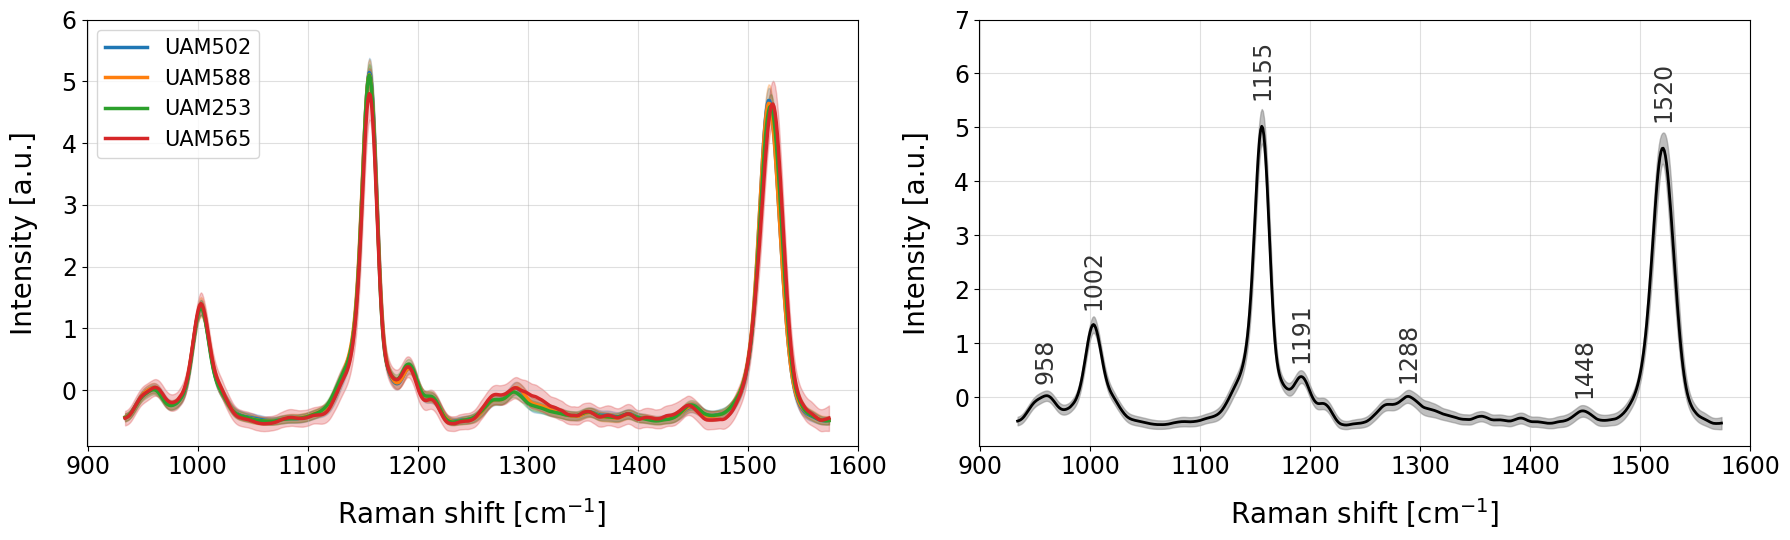

In [ ]:


# Drop non-numeric columns
numeric_data = corrected_combined.drop(columns=['X', 'Y', 'name', 'date', 't_exp', 'medium', 'especie'])

# Calculate mean and std for each species
media_UAM502 = numeric_data[corrected_combined['especie'] == "UAM502"].mean(axis=0).values
std_UAM502 = numeric_data[corrected_combined['especie'] == "UAM502"].std(axis=0).values

media_UAM588 = numeric_data[corrected_combined['especie'] == "UAM588"].mean(axis=0).values
std_UAM588 = numeric_data[corrected_combined['especie'] == "UAM588"].std(axis=0).values

media_UAM253 = numeric_data[corrected_combined['especie'] == "UAM253"].mean(axis=0).values
std_UAM253 = numeric_data[corrected_combined['especie'] == "UAM253"].std(axis=0).values

media_UAM565 = numeric_data[corrected_combined['especie'] == "UAM565"].mean(axis=0).values
std_UAM565 = numeric_data[corrected_combined['especie'] == "UAM565"].std(axis=0).values

# Calculate overall mean and std across all species
media_df = numeric_data.mean(axis=0).values
std_df = numeric_data.std(axis=0).values


# Define Raman shifts
ramanshifts = np.arange(934, 1575, 1)

# Ensure peak indices match Raman shifts
peaks = [24, 68, 257, 354, 514]
peaks2 = [221, 586]


# Plotting
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(18, 5.5))

# Subplot 1
ax1.plot(ramanshifts, media_df, lw=2, color='black')
ax1.fill_between(ramanshifts, media_df - std_df, media_df + std_df, color='gray', alpha=0.5)
for peak in peaks:
    ax1.annotate(f'{ramanshifts[peak]:.0f}', (ramanshifts[peak], (media_df + std_df)[peak]), 
                 textcoords="offset points", xytext=(1, 9), ha='center', fontsize=17, rotation=90, alpha=0.8)
for peak in peaks2:
    ax1.annotate(f'{ramanshifts[peak]:.0f}', (ramanshifts[peak], (media_df + std_df)[peak]), 
                 textcoords="offset points", xytext=(1, 12), ha='center', fontsize=17, rotation=90, alpha=0.8)
ax1.grid(alpha=0.4)
ax1.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=20, labelpad=12)
ax1.set_ylabel('Intensity [a.u.]', fontsize=20, labelpad=17)
ax1.set_xticks(np.arange(800, 1800, 100))
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.set_xlim([ramanshifts.min()-35, ramanshifts.max()+26])
ax1.set_ylim([-0.9, 7])

# Subplot 2
ax2.plot(ramanshifts, media_UAM502, label='UAM502', color='C0', lw=2.5)
ax2.fill_between(ramanshifts, media_UAM502 - std_UAM502, media_UAM502 + std_UAM502, color='C0', alpha=0.25)
ax2.plot(ramanshifts, media_UAM588, label='UAM588', color='C1', lw=2.5)
ax2.fill_between(ramanshifts, media_UAM588 - std_UAM588, media_UAM588 + std_UAM588, color='C1', alpha=0.25)
ax2.plot(ramanshifts, media_UAM253, label='UAM253', color='C2', lw=2.5)
ax2.fill_between(ramanshifts, media_UAM253 - std_UAM253, media_UAM253 + std_UAM253, color='C2', alpha=0.25)
ax2.plot(ramanshifts, media_UAM565, label='UAM565', color='C3', lw=2.5)
ax2.fill_between(ramanshifts, media_UAM565 - std_UAM565, media_UAM565 + std_UAM565, color='C3', alpha=0.25)
ax2.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=20, labelpad=12)
ax2.set_ylabel('Intensity [a.u.]', fontsize=20, labelpad=17)
ax2.set_xticks(np.arange(800, 1800, 100))
ax2.tick_params(axis='both', which='major', labelsize=17)
ax2.set_xlim([ramanshifts.min()-35, ramanshifts.max()+26])
ax2.grid(alpha=0.4)
ax2.legend(loc='upper left', prop={'size': 15})
ax2.set_ylim([-0.9, 6])

plt.tight_layout()
fig.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figure_meanspectra.svg', format='svg', bbox_inches='tight')
plt.show()


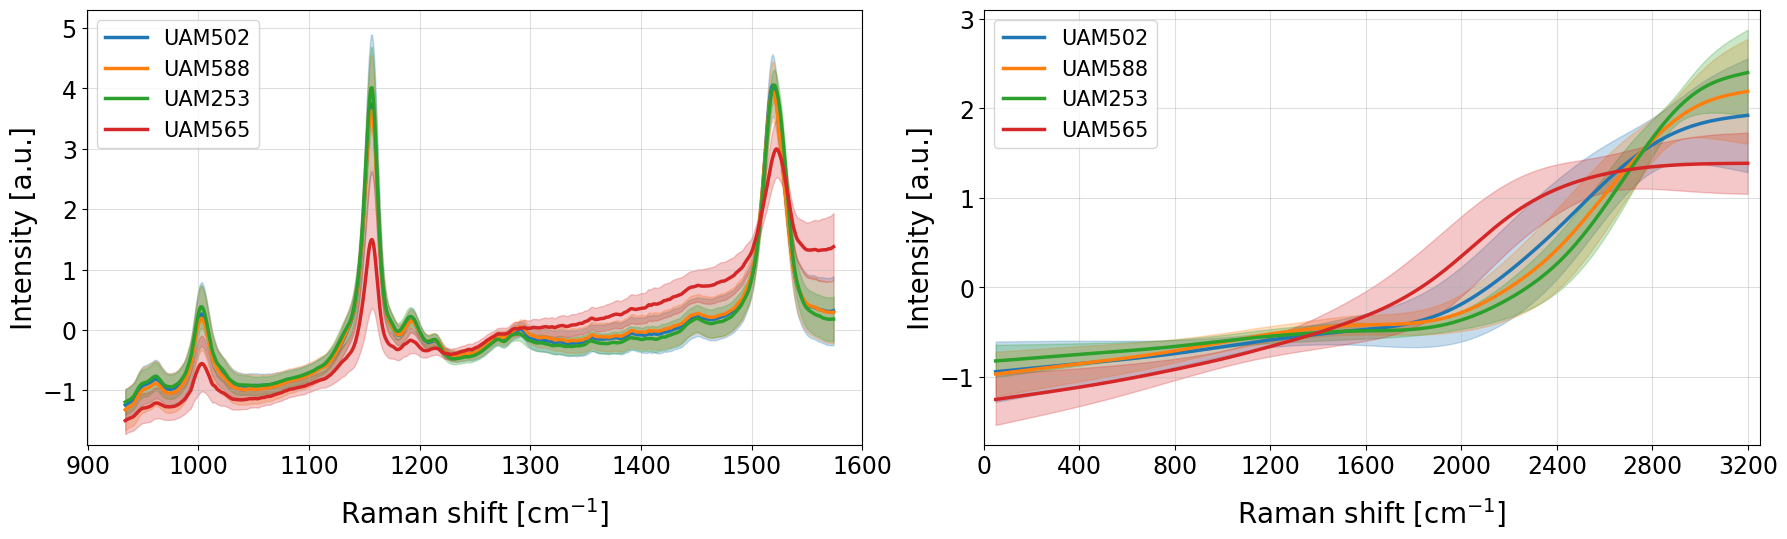

In [161]:

# Function to calculate mean and standard deviation for each species
def calculate_mean_std(data, species_col, species_list, drop_cols):
    numeric_data = data.drop(columns=drop_cols)
    mean_std_dict = {}
    for species in species_list:
        species_data = numeric_data[data[species_col] == species]
        mean_std_dict[species] = {
            "mean": species_data.mean(axis=0).values,
            "std": species_data.std(axis=0).values
        }
    overall_mean = numeric_data.mean(axis=0).values
    overall_std = numeric_data.std(axis=0).values
    return mean_std_dict, overall_mean, overall_std

# Species and non-numeric columns
species_list = ["UAM502", "UAM588", "UAM253", "UAM565"]
non_numeric_cols = ['X', 'Y', 'name', 'date', 't_exp', 'medium', 'especie']

# Calculate statistics for "originals_combined"
originals_mean_std, overall_mean_originals, overall_std_originals = calculate_mean_std(
    originals_combined, species_col="especie", species_list=species_list, drop_cols=non_numeric_cols
)

# Calculate statistics for "baselines_combined"
baselines_mean_std, overall_mean_baselines, overall_std_baselines = calculate_mean_std(
    baselines_combined, species_col="especie", species_list=species_list, drop_cols=non_numeric_cols
)

# Define Raman shifts
ramanshifts1 = np.arange(934, 1575, 1)
ramanshifts2 = np.arange(50, 3200, 1)

# Function to plot spectra
def plot_spectra(ax, ramanshifts, mean_std_dict, species_list):
    for i, species in enumerate(species_list):
        ax.plot(ramanshifts, mean_std_dict[species]["mean"], label=species, lw=2.5, color=f"C{i}")
        ax.fill_between(
            ramanshifts,
            mean_std_dict[species]["mean"] - mean_std_dict[species]["std"],
            mean_std_dict[species]["mean"] + mean_std_dict[species]["std"],
            color=f"C{i}", alpha=0.25
        )
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=20, labelpad=12)
    ax.set_ylabel('Intensity [a.u.]', fontsize=20, labelpad=3)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.grid(alpha=0.4)
    ax.legend(loc='upper left', prop={'size': 15})

# Create the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5.5))

# Subplot 1: Originals
plot_spectra(ax1, ramanshifts1, originals_mean_std, species_list)
ax1.set_xticks(np.arange(800, 1800, 100))
ax1.set_xlim([ramanshifts1.min() - 35, ramanshifts1.max() + 26])
ax1.set_ylim([-1.9, 5.3])

# Subplot 2: Baselines
plot_spectra(ax2, ramanshifts2, baselines_mean_std, species_list)
ax2.set_xticks(np.arange(0, 3400, 400))
ax2.set_xlim([ramanshifts2.min() - 50, ramanshifts2.max() + 50])

# Save and display the figure
plt.tight_layout()
fig.savefig(
    'C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figure_meanspectra_originals_baselines.svg',
    format='svg', bbox_inches='tight'
)
plt.show()


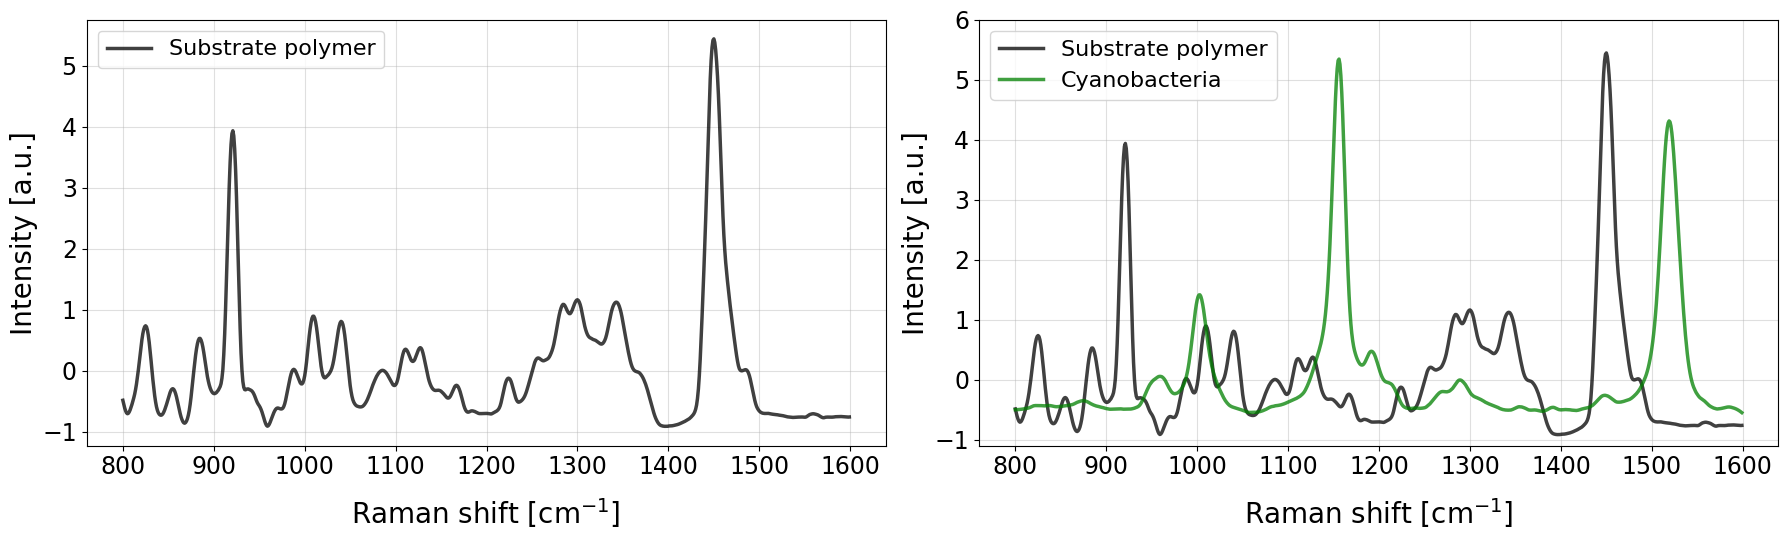

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
plastico = pd.read_csv(r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\plastico.csv')
ciano = pd.read_csv(r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\ciano_neubauer.csv')

# Definir los desplazamientos Raman
ramanshifts = np.arange(800, 1600, 1)

# Calcular media y desviación estándar para los espectros
mean_std_dict = {
    "Substrate polymer": {
        "mean": plastico.mean(axis=0).values,
        "std": plastico.std(axis=0).values
    },
    "Cyanobacteria": {
        "mean": ciano.mean(axis=0).values,
        "std": ciano.std(axis=0).values
    }
}

colors = ['black', 'green']

# Lista de especies
species_list_plastico = ["Substrate polymer"]
species_list_both = ["Substrate polymer", "Cyanobacteria"]

# Definir la función para graficar los espectros
def plot_spectra(ax, ramanshifts, mean_std_dict, species_list):
    for i, species in enumerate(species_list):
        ax.plot(ramanshifts, mean_std_dict[species]["mean"], label=species, lw=2.5, alpha = 0.75, color=colors[i])
        ax.fill_between(
            ramanshifts,
            mean_std_dict[species]["mean"] - mean_std_dict[species]["std"],
            mean_std_dict[species]["mean"] + mean_std_dict[species]["std"],
            color=f"C{i}", alpha=0.25
        )
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=20, labelpad=12)
    ax.set_ylabel('Intensity [a.u.]', fontsize=20, labelpad=3)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.grid(alpha=0.4)
    ax.legend(loc='upper left', prop={'size': 16})
    

# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5.5))

# Subplot 1: Solo plástico
plot_spectra(ax1, ramanshifts, mean_std_dict, species_list_plastico)
ax1.set_xticks(np.arange(800, 1601, 100))

# Subplot 2: Plástico y cianobacterias solapados
plot_spectra(ax2, ramanshifts, mean_std_dict, species_list_both)
ax2.set_xticks(np.arange(800, 1601, 100))
ax2.set_ylim([-1.1, 6])


# Guardar y mostrar la figura
plt.tight_layout()
fig.savefig(
    r'C:\Users\fmantecam\OneDrive - UNICAN\Figuraspapercianos\figure_meanspectra_plastico_ciano.svg',
    format='svg', bbox_inches='tight'
)
plt.show()


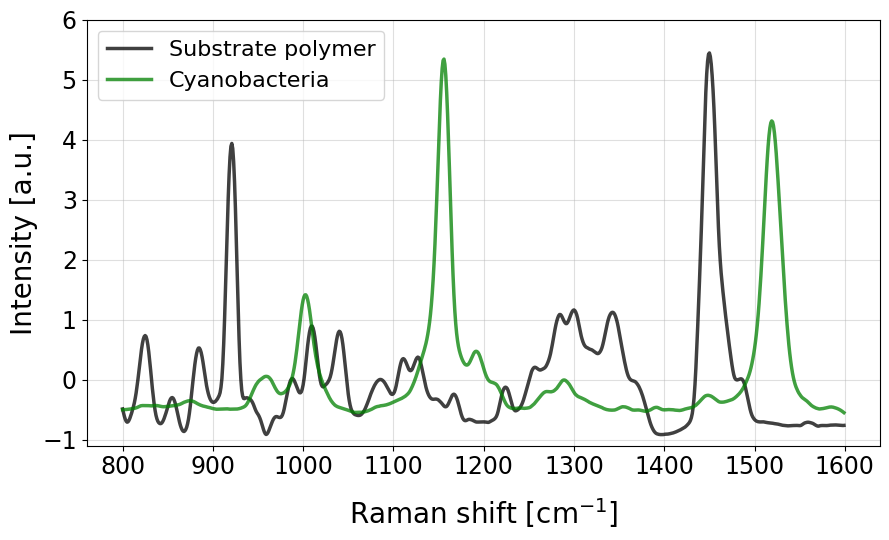

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Definir los desplazamientos Raman
ramanshifts = np.arange(800, 1600, 1)

# Calcular media y desviación estándar para los espectros
mean_std_dict = {
    "Substrate polymer": {
        "mean": plastico.mean(axis=0).values,
        "std": plastico.std(axis=0).values
    },
    "Cyanobacteria": {
        "mean": ciano.mean(axis=0).values,
        "std": ciano.std(axis=0).values
    }
}

colors = ['black', 'green']

# Lista de especies
species_list_both = ["Substrate polymer", "Cyanobacteria"]

# Definir la función para graficar los espectros
def plot_spectra(ax, ramanshifts, mean_std_dict, species_list):
    for i, species in enumerate(species_list):
        ax.plot(ramanshifts, mean_std_dict[species]["mean"], label=species, lw=2.5, alpha = 0.75, color=colors[i])
        ax.fill_between(
            ramanshifts,
            mean_std_dict[species]["mean"] - mean_std_dict[species]["std"],
            mean_std_dict[species]["mean"] + mean_std_dict[species]["std"],
            color=f"C{i}", alpha=0.25
        )
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=20, labelpad=12)
    ax.set_ylabel('Intensity [a.u.]', fontsize=20, labelpad=3)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.grid(alpha=0.4)
    ax.legend(loc='upper left', prop={'size': 16})
    

# Crear la figura y el subplot
fig, ax2 = plt.subplots(figsize=(9, 5.5))

# Plástico y cianobacterias solapados
plot_spectra(ax2, ramanshifts, mean_std_dict, species_list_both)
ax2.set_xticks(np.arange(800, 1601, 100))
ax2.set_ylim([-1.1, 6])

# Guardar y mostrar la figura
plt.tight_layout()
fig.savefig(
    r'C:\Users\fmantecam\OneDrive - UNICAN\Figuraspapercianos\figure_meanspectra_plastico_ciano_2.svg',
    format='svg', bbox_inches='tight'
)
plt.show()


In [ ]:
ramanshifts = np.arange(934, 1575, 1)

In [164]:
ramanshifts = np.arange(800, 1600, 1)

In [ ]:
plastico = pd.read_csv(f'C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\plastico.csv')
ciano = pd.read_csv(f'C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\ciano_neubauer.csv')


ramanshifts = np.arange(800, 1600, 1)